In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
data = pd.read_csv('./data/processed_data_for_model.csv')

In [3]:
drop_hospitals = True

if drop_hospitals:
    selected_cols = []
    for col in list(data):
        if col[0:8] == 'hospital':
            pass
        else:
            selected_cols.append(col)
    
    data = data[selected_cols]

In [4]:
data.head()

,parity,prevcaes,noscans,pyrexia,meconium,apgar5,bmi,age,gest,analgesia_I,...,delivery_E,delivery_L,delivery_O,delivery_R,delivery_S,delivery_V,onset_E,onset_I,onset_N,onset_S
0,4.0,0.0,1.0,False,False,9.0,22,25,41,True,...,0,0,0,0,1,0,0,0,0,1
1,0.0,0.0,3.0,False,True,7.0,20,34,41,True,...,0,0,0,0,0,0,0,0,0,1
2,0.0,0.0,1.0,False,False,10.0,21,34,39,False,...,0,0,0,0,1,0,0,0,0,1
3,0.0,0.0,2.0,False,False,10.0,23,30,39,True,...,0,0,0,0,1,0,0,0,0,1
4,1.0,0.0,1.0,False,False,10.0,21,29,39,True,...,0,0,0,0,1,0,0,0,0,1


Balance data

In [5]:
mask = data['apgar5'] <7
pos_class = data[mask]

mask = data['apgar5'] >= 7
neg_class = data[mask].sample(len(pos_class))

data = pd.concat([neg_class, pos_class], axis=0).sample(frac=1.0, random_state=42)
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

Split X and y

In [6]:
y = data['apgar5'] < 7
X = data.drop('apgar5', axis=1)

In [7]:
# Set up splits
number_of_splits = 5
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X, y)

5

In [8]:
# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []
importances = []

# Loop through the k-fold splits
counter = 0
for train_index, test_index in skf.split(X, y):
    counter += 1
    
    # Get X and Y train/test
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # Fit model
    model = HistGradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)[:,1]
    y_class = model.predict(X_test)
    observed.append(y_test)
    predicted_proba.append(y_probs)
    
    # Print accuracy
    accuracy = np.mean(y_class == y_test)
    print (
        f'Run {counter}, accuracy: {accuracy:0.3f}')

Run 1, accuracy: 0.735
Run 2, accuracy: 0.740
Run 3, accuracy: 0.722
Run 4, accuracy: 0.717
Run 5, accuracy: 0.710


In [9]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(number_of_splits):
    # Get fpr, tpr and thresholds foir each k-fold from scikit-learn's ROC method
    fpr, tpr, thresholds = roc_curve(observed[i], predicted_proba[i])
    # Use scikit-learn's method for calulcating auc
    roc_auc = auc(fpr, tpr)
    # Store results
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)
    # Print auc result
    print (f'Run {i} AUC {roc_auc:0.4f}')

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')

Run 0 AUC 0.8045
Run 1 AUC 0.8033
Run 2 AUC 0.7951
Run 3 AUC 0.7945
Run 4 AUC 0.7857

Mean AUC: 0.7966
SD AUC: 0.0068


SHAP (to all data)

In [10]:
model = HistGradientBoostingClassifier()
model.fit(X, y)

explainer = shap.TreeExplainer(model)
shap_values_extended = explainer(X)
shap_values = explainer.shap_values(X)
shap_values_extended[0]

.values =
array([-9.49593366e-02,  1.83778730e-02, -7.13431804e-02, -8.59544501e-03,
       -1.48991892e-01, -4.47835824e-04, -1.77005408e-02, -4.24512061e-01,
       -1.28121216e-02, -1.44008251e-01,  1.29599540e-02, -4.20663154e-01,
        2.65459021e-03, -2.21542872e-03, -3.13659490e-04, -3.61137812e-03,
       -1.05541361e-05, -4.00209008e-02, -1.78505776e-03, -2.72292106e-02,
       -9.88086362e-04, -2.74207538e-01, -7.83944927e-02, -2.73950995e-03,
       -3.53685171e-02, -2.57592202e-03, -4.58118533e-02,  4.84315236e-03,
        7.78055299e-03,  1.31168952e-03, -2.23092861e-03, -1.48184715e-02,
       -8.29272844e-04,  0.00000000e+00, -9.57409024e-03, -4.07395715e-03,
       -1.35620394e-02])

.base_values =
array([0.16961455])

.data =
array([1.0, 0.0, 1.0, False, False, 23, 28, 40, True, False, False, False,
       False, False, False, False, False, False, False, False, False, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=object)

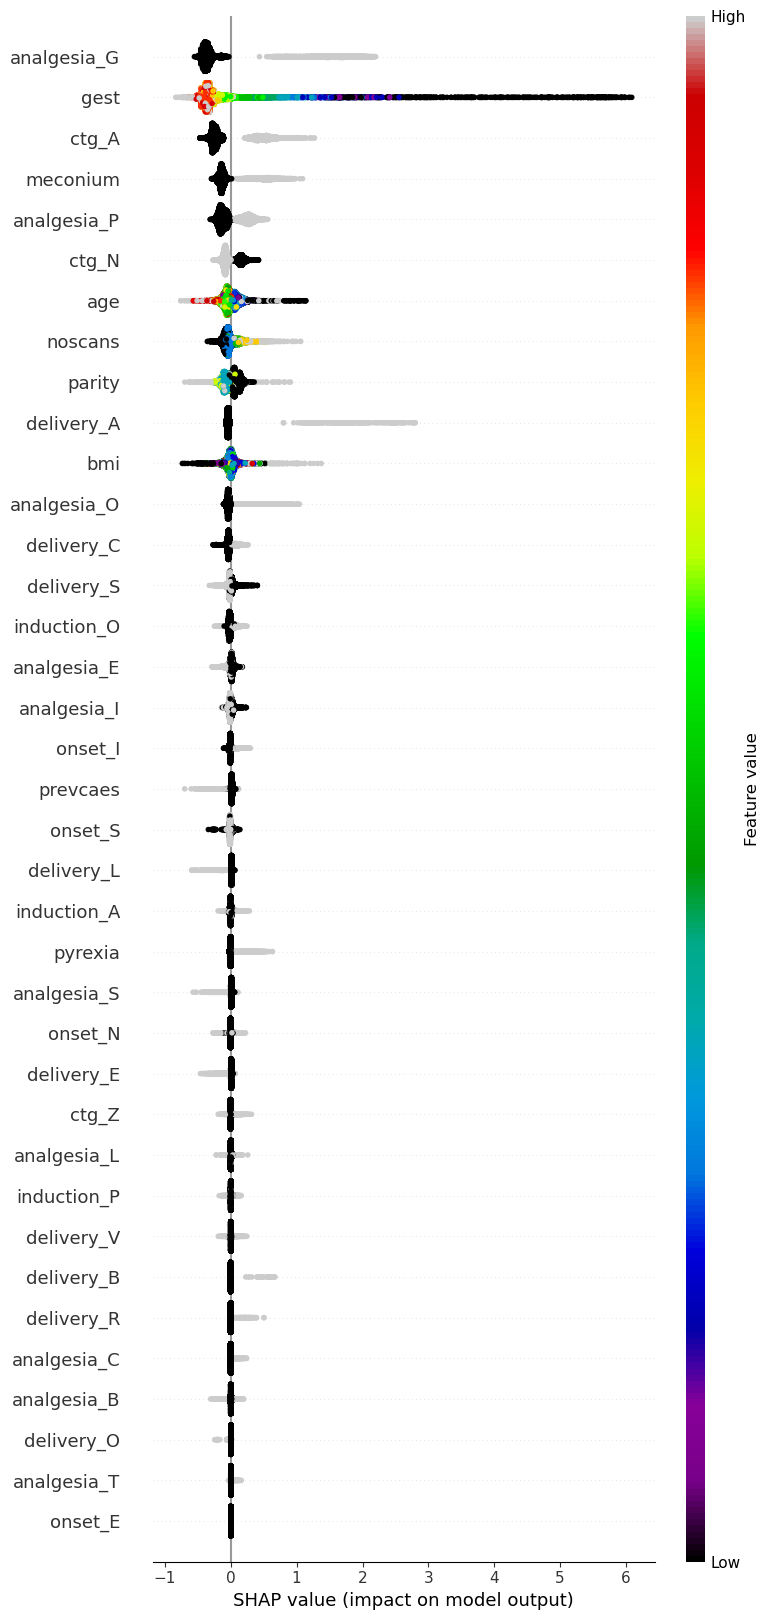

In [11]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X,
                  feature_names=list(X),
                  max_display=60,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)

plt.show()

In [12]:
df = pd.DataFrame(index=list(X))
df['feature_index'] = np.arange(len(list(X)))
df['mean_shap'] = np.mean(shap_values, axis=0)
df['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df.sort_values('mean_abs_shap', ascending=False, inplace=True)

top_shap = list(df.index)
df.head(10)

,feature_index,mean_shap,mean_abs_shap
analgesia_G,11,-0.000386,0.586728
gest,7,0.014550,0.543875
ctg_A,21,-0.007984,0.326935
meconium,4,-0.001041,0.222378
analgesia_P,9,-0.001126,0.168609
ctg_N,22,0.010831,0.117084
age,6,0.001205,0.099960
noscans,2,-0.000422,0.095776
parity,0,0.003056,0.092250
delivery_A,24,0.001315,0.080748


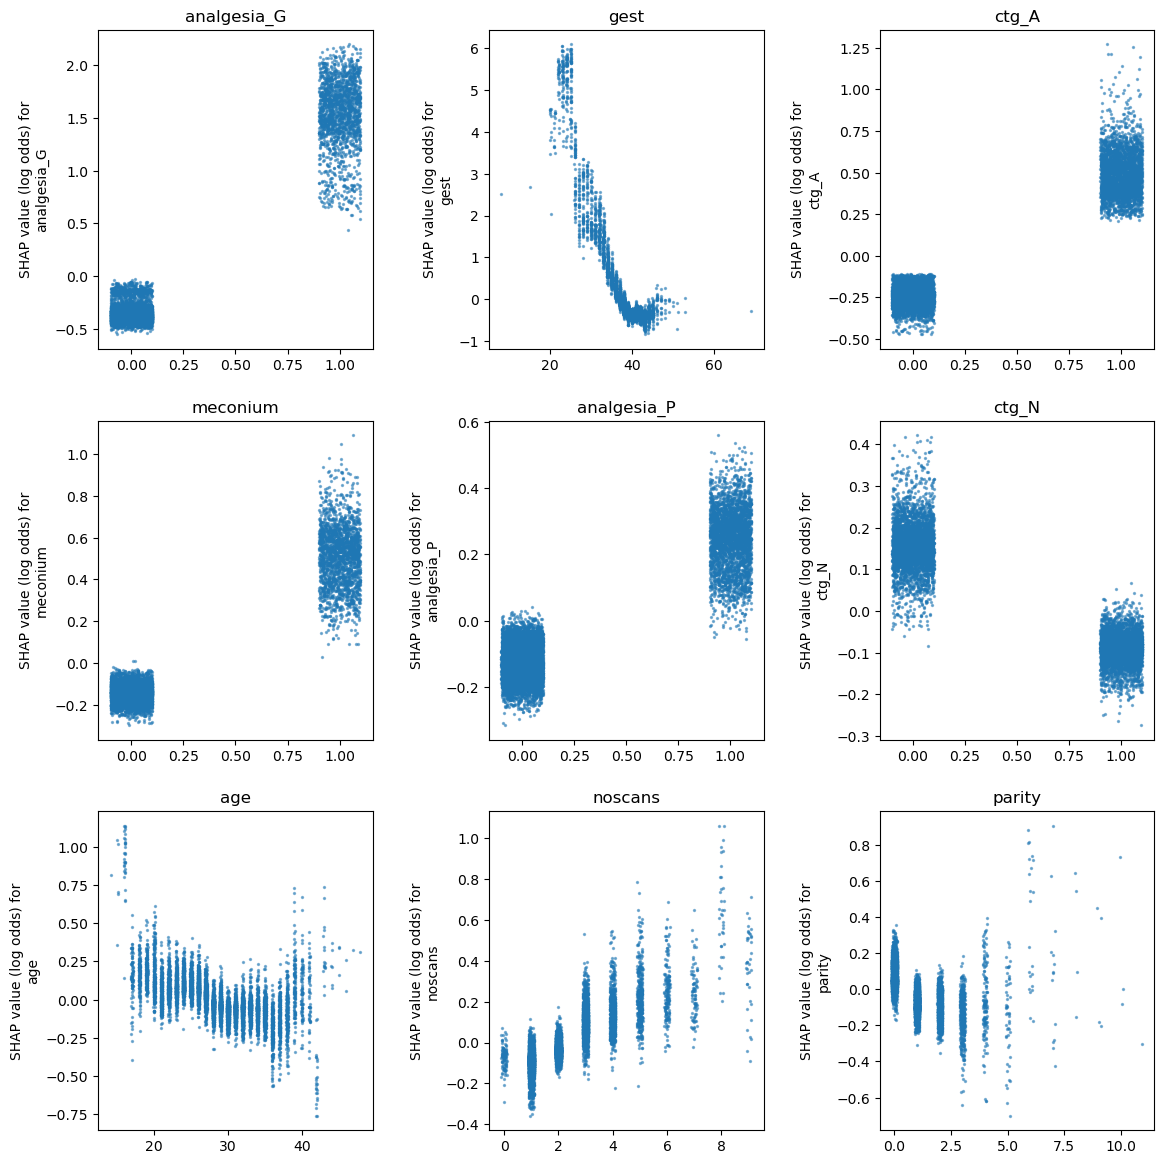

In [13]:
feat_to_show = top_shap[0:9]

fig = plt.figure(figsize=(12,12))
for n, feat in enumerate(feat_to_show):
    feat_index = int(df.loc[feat]['feature_index']) 
    ax = fig.add_subplot(3,3,n+1)

    shap_data = shap_values_extended[:].values[:,feat_index]
    feature_data = shap_values_extended[:].data[:,feat_index]

    jitter = -0.1 + (np.random.rand(len(feature_data))*0.2)

    ax.scatter(feature_data + jitter, shap_data, alpha=0.5, s=2)
  
    
    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
plt.savefig('./output/shap_1.jpg', dpi=300)

plt.show()
